# Comparing Option Pricing Methods in kdb+/q

In this notebook, we compare the use of both **Monte Carlo** (MC) and **Quasi-Monte Carlo** (QMC) methods in the process of pricing Asian and European call options. In doing so, we consider the use of two discretization schemes - **standard discretization** and **Brownian bridge construction**. The **Black-Scholes** price for each market is compared to an average price generated using the following combinations of simulation and discretization methods:

- Pseudo-random number generation (MC) with standard discretization.
- Sobol sequences (QMC) with standard discretization.
- Sobol sequences (QMC) with Brownian Bridge construction.

Note that the methods demonstrated below follow the work presented in the paper [S. Kucherenko et. al 2007](http://www.broda.co.uk/gsa/wilmott_GSA_SK.pdf).

The Black-Scholes function for each market produces a closed form solution with a deterministic result, while the MC/QMC functions perform a number of random experiments and return an average price, based on the option type and the strike price.

Once both the Black-Scholes and MC/QMC prices have been calculated for each market, the RMSE can be calculated between the two. This is demonstrated in the final [example](#Example) below. The process is repeated for an increasing number of paths, with resulting errors compared.

### Requirements

The technical dependencies required to run this notebook are as follows:
- [embedPy](https://github.com/KxSystems/embedPy)
- [Sobol C++ library](https://www.broda.co.uk/software.html) - can be found within the option pricing library provided
- matplotlib

---

## Load q scripts

We start by loading in the library of option pricing scripts. These include the functions described in detail below, wrappers for the C++ random and sobol sequence number generators, along with the functions required to produce both cumulative and inverse cumulative normal distributions, and graphics functions used throughout this notebook.

In [1]:
\c 20 70
\l ../op.q
loadfile`:init.q

---

<a id='BS'></a>
## Black-Scholes Option Pricing

A common model used in finance to calculate the price of call options is Black-Scholes, where the formula required for each market is derived from the [Black Scholes equation](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_equation). In this notebook, we look specifically at the Black-Scholes models for Asian and European call options. The function for each market produces a closed form solution with a deterministic result.

For [European call options](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model), the price of the corresponding option at time $t$, $P(S_{t},t)$, is given by:

$$\begin{eqnarray}
d_{1} = \frac{1}{\sigma\sqrt{T-t}}\Big[ln\Big(\frac{S_{t}}{K}\Big)+\Big((r-q)+\frac{\sigma^{2}}{2}\Big)(T-t)\Big]
\end{eqnarray}$$

$$\begin{eqnarray}
d_{2} = d_{1}-\sigma\sqrt{T-t}
\end{eqnarray}$$

$$\begin{eqnarray}
P(S_{t},t) = S_{t}e^{-q(T-t)}N(d_{1})-Ke^{-r(T-t)}N(d_{2})
\end{eqnarray}$$

Where $T$ is the expiry, $S_{t}$ is the price of the underlying asset at time $t$, $K$ is the strike price of the option, $\sigma$ is the volatility and $r$ is the interest rate. Note that the price is discounted by the dividends, $q$, throughout.

For Asian call options, we implement the same formula, using an adjusted $S_{t}$ and $\sigma^{2}$:

$$\begin{eqnarray}
\mu_{adj} = \frac{1}{2}\Big(r-\frac{\sigma}{2}\Big)\Big(1+\frac{1}{n}\Big)
\end{eqnarray}$$

$$\begin{eqnarray}
\sigma^{2}_{adj} = \frac{\sigma^2}{3}\Big(1+\frac{1}{n}\Big)\Big(1+\frac{1}{2n}\Big)
\end{eqnarray}$$

$$\begin{eqnarray}
{S_{t}}_{adj} = S_{t}e^{\frac{1}{2}\sigma^{2}_{adj}(T-t)+\mu_{adj}-r}
\end{eqnarray}$$

Where $n$ is the number of timesteps.

The Black-Scholes function for each option type are written in q below.

The required parameters for each function must be specified in a dictionary prior to use and are as follows:
- `s` - Asset price at $t=0$
- `k` - Strike
- `v` - Volatility
- `r` - Interest rate
- `q` - Dividends
- `t` - Expiry

Note that the Black-Scholes price of an Asian call option is also dependent on the number of timesteps `n`.

In [2]:
nsteps:512
pd:`s`k`v`r`q`t!100 100 .2 .05 0 1
-1"European Black Scholes Price: ",string bseuro:bsEuroCall pd;
-1"Asian Black Scholes Price:    ",string bsasia:bsAsiaCall[nsteps]pd;

European Black Scholes Price: 10.45058
Asian Black Scholes Price:    5.556009


---

<a id='MC'></a>
## Monte Carlo and Quasi-Monte Carlo Simulations

In order to generate option prices using MC or QMC methods, a number of experiments must be performed. In each experiment, we:
1. Randomly generate n random numbers, either pseudo-random (MC) or Sobol sequence (QMC).
2. Convert into a normal distribution using `invcnorm`.
3. Convert into a Wiener path random walk using standard discretization or Brownian bridge construction.
4. Convert into an asset price path based on the parameters `s`, `v`, `r`, `q` and `t`.
5. Convert into an option price based on the option type and strike price, `k`.

The prices produced are then averaged to get a final predicted price.

In this section we demonstrate the process using Sobol sequences (QMC) paired with Brownian bridge construction.

### 1. Random number generation

In the example below, 512 random numbers are generated for both pseudo-random numbers and Sobol sequences, with results plotted for comparison.

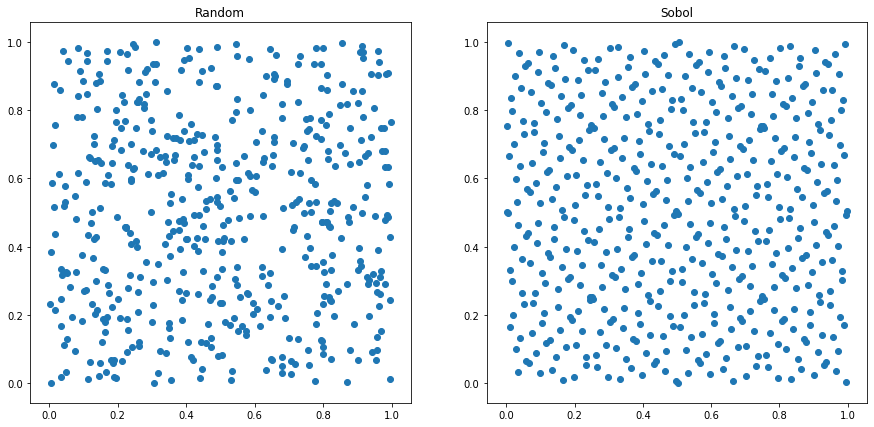

In [3]:
\S 20
rdm:(2;nsteps)#mtrand3 2*nsteps
sob:flip sobolrand each nsteps#2
subplot[rdm;sob;"Random";"Sobol";`scatter]

We can also plot the distribution of points in one dimension for each case below.

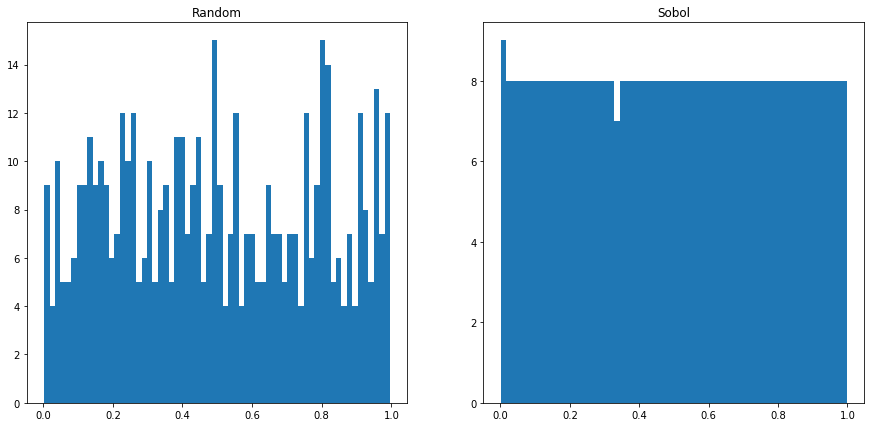

In [4]:
subplot[first rdm;first sob;"Random";"Sobol";`hist]

It is clear that the pseudo-random numbers are not evenly distributed, with a points clustering together in some sections, while leaving large portions of white space in others.

In contrast, the Sobol sequence plot exhibits a much more even distribution where points are better spaced out, with few points clumping together.

### 2. Convert to a Gaussian Distribution

The generated sequences are then converted from a uniform distribution to a gaussian distribution. Following this conversion around 68% of the values lie within one standard deviation, while two standard deviations account for around 95% and three account for 99.7%.

<img src="graphics/gaussian.png" style="height:400px">

<u><b><center>[Gaussian Distribution](https://en.wikipedia.org/wiki/Normal_distribution)</center></b></u>

This is demonstrated using the inverse cumulative normal function, `invcnorm`.

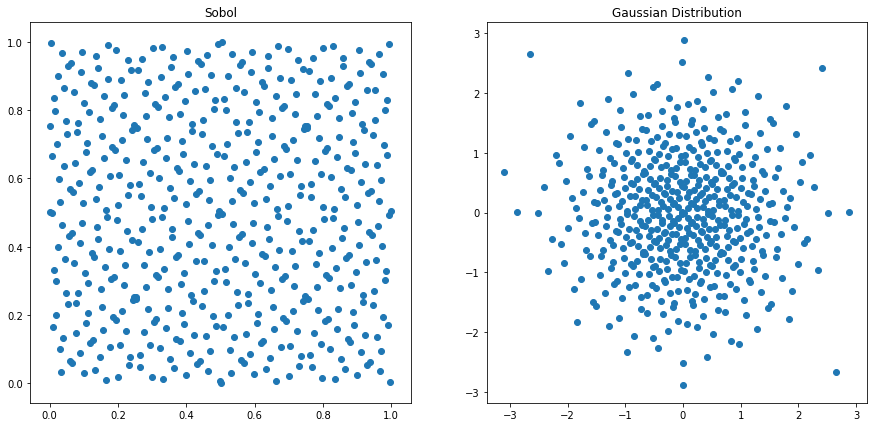

In [5]:
zsob:invcnorm each sob
subplot[sob;zsob;"Sobol";"Gaussian Distribution";`scatter]

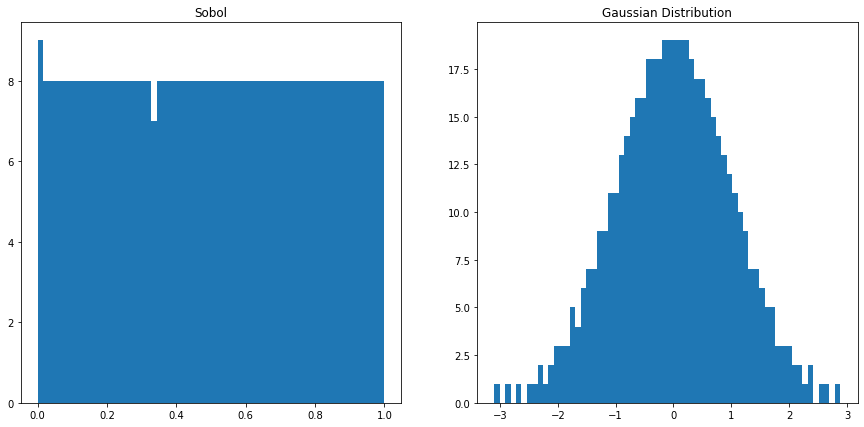

In [6]:
subplot[first sob;first zsob;"Sobol";"Gaussian Distribution";`hist]

As expected the points now exhibit a Gaussian curve when plotted in one dimension.

### 3. Convert into a Wiener path random walk

A large portion of financial problems can be solved by calculating the relevant Weiner path integral. Such solutions are formalized by using either standard discretization or Brownian bridge construction. In the standard approximation, this Weiner path can be found by taking the cumulative sum across the random values converted to a gaussian distribution.

To construct a Brownian bridge, the order of steps in the Weiner path have to be determined. The overall idea is to create a path with n timesteps (from 0 to n-1) where we want to calculate the last step first, followed by the mid-step and then fill in the rest.

The process is as follows:

1. Start by calculating the first and last steps, where we assume that the first index has a value equal to 0.
2. Calculate the mid-step, noting that for floating point values we round down.
3. Then follow an iterative bisecting process (see note below):
    1. Start with the current mid-point.
    2. Move to the right, to the next index which is already in the path.
    3. Find the midpoint between that index and the index to its right.
    4. Move to the new midpoint.
4. This process of moving to the right and finding the midpoint between indices is then repeated until there are no further indices left to add to the path.

<div class="alert alert-danger">
<b>Note:</b>

1. The sequence acts as a loop, such that moving to point n is equivalent to index 0.

2. It is only possible to move between steps which have already been added to the final path.
</div>

An example of building up a Brownian bridge is shown in the diagram below, where we have a total of 15 timesteps (from 0 to 14).

<img src="graphics/bbconstruct.png">

<u><center><b>The construction of a Brownian bridge over 14 steps</b> ([P. Jäckel 2001](http://inis.jinr.ru/sl/M_Mathematics/MV_Probability/MVspf_Stochastics%20in%20finance/Jaeckel%20Monte-Carlo.pdf))</center></u>

The q code to build both a Brownian bridge and Wiener path random walk are shown below.

We can demonstrate how the Brownian bridge is built up using `bbdemo` which will output a table with n timesteps (in this case n = 6), showing the order in which steps are added to the path.

In [7]:
\t 1000
bbdemo[5;1.]


i0 i1 i2 i3 i4 i5
-----------------
                 

i0 i1 i2 i3 i4 i5
-----------------
X                

i0 i1 i2 i3 i4 i5
-----------------
X              X 

i0 i1 i2 i3 i4 i5
-----------------
X     X        X 

i0 i1 i2 i3 i4 i5
-----------------
X  X  X        X 

i0 i1 i2 i3 i4 i5
-----------------
X  X  X  X     X 

i0 i1 i2 i3 i4 i5
-----------------
X  X  X  X  X  X 

i0 i1 i2 i3 i4 i5
-----------------



When recording the order of steps in the path, we also take note of the left and right weights and indices, and the corresponding sigma value for each step in the sequence. Below we show this for 512 timesteps and 1 unit of time and subsequently plot the sigma value for each index in the Brownian Bridge.

In [8]:
dt:1
show b:last value bbex:bbridge[nsteps;dt]

bidx ridx lidx lwt rwt sigma   
-------------------------------
511  511  511          22.62742
255  511  -1   0.5 0.5 11.31371
127  255  -1   0.5 0.5 8       
383  511  255  0.5 0.5 8       
63   127  -1   0.5 0.5 5.656854
191  255  127  0.5 0.5 5.656854
319  383  255  0.5 0.5 5.656854
447  511  383  0.5 0.5 5.656854
31   63   -1   0.5 0.5 4       
95   127  63   0.5 0.5 4       
159  191  127  0.5 0.5 4       
223  255  191  0.5 0.5 4       
287  319  255  0.5 0.5 4       
351  383  319  0.5 0.5 4       
415  447  383  0.5 0.5 4       
..


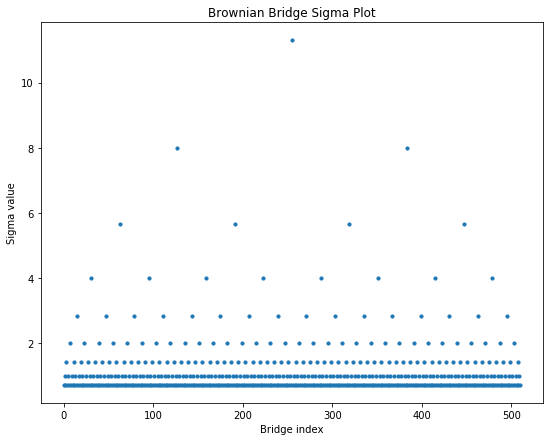

In [9]:
plt[`:figure]`figsize pykw 9 7;
plt[`:title]"Brownian Bridge Sigma Plot";
plt[`:scatter][;;10]. (1_b)`bidx`sigma;
plt[`:xlabel]"Bridge index";
plt[`:ylabel]"Sigma value";
plt[`:show][];

Bringing everything together, we can calculate the Wiener path random walk for a Sobol sequence with 512 timesteps using the Brownian bridge constructed in the previous cell. Note that the function `wpath` takes the following arguments:
- `n` - Number of timesteps.
- `d` - Dictionary indicating whether to use standard discretization or Brownian bridge construction, and whether to use Sobol sequences (`1b`) or pseudo-random numbers (`0b`). If using a Brownian bridge, the initial Brownian bridge must be passed in, if not use `(::)`.

-0.3261343 -0.124455 -0.7468779 -0.7283514 -0.02784596 -0.1341059 -0.09226226 0.1405605 -0.5829703 -2.99527..


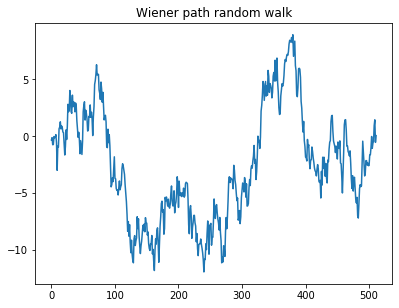

In [10]:
\c 200 110
d:`bb`sobol!(bbex;1b)
show w:wpath[nsteps;d]
plt[`:title]"Wiener path random walk";
plt[`:plot]w;
plt[`:show][];

### 4. Convert into asset price path

At this point it is possible to convert the Wiener path to an asset price path using the function below.

Here we calculate and plot results for the asset price path for 512 timesteps, Sobol sequence number generation and Brownian bridge construction.

99.38324 100.3337 98.71287 98.87992 99.46112 97.79218 97.98561 97.55094 97.15046 98.10176 98.08446 97.45974..


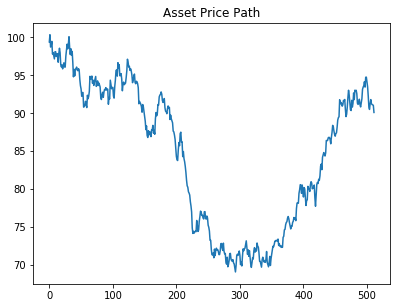

In [11]:
show s:spath[nsteps;d;pd]
plt[`:title]"Asset Price Path";
plt[`:plot]s;
plt[`:show][];

### 5. Convert into option price

Lastly, we average the asset price path to find a single price for the MC/QMC method. This will allow for comparison between the predicted price and the Black-Scholes equivalent.

For 512 timesteps we get the following results.

In [12]:
npaths:16
-1"European Monte Carlo Price: ",string mcEuroCall[npaths;nsteps;`bb`sobol!(bbex;1b);pd];
-1"Asian Monte Carlo Price:    ",string mcAsiaCall[npaths;nsteps;`bb`sobol!(bbex;1b);pd];

European Monte Carlo Price: 8.675775
Asian Monte Carlo Price:    5.544817


Remembering that for the Black-Scholes option prices we had:

In [13]:
-1"European Black-Scholes Price: ",string bseuro;
-1"Asian Black-Scholes Price:    ",string bsasia;

European Black-Scholes Price: 10.45058
Asian Black-Scholes Price:    5.556009


---

<a id='Example'></a>
## Example

In this section we deploy all of the aforementioned techniques and compare the results.

### Parameters

First we need to create a dictionary of parameters as shown previously.

In [14]:
pd:`s`k`v`r`q`t!100 100 .2 .05 0 1

We also need to initialize the number of paths (experiments), steps and trials.

In [15]:
l:20                        / Number of trials
show m:"j"$xexp[2;3+til 8]  / Number of paths
n:1024                      / Number of steps

8 16 32 64 128 256 512 1024


Given that the initial Brownian bridge will be the same throughout, it can also be initialized and passed in as an argument.

In [16]:
bb:bbridge[n;1]

### Run experiments
The below functions calculate the RMSE between the Black-Scholes prices and MC/QMC prices for each market.

In [17]:
/ Run all techniques for option pricing
runall:{[bb;pd;l;n;m]
 st:.z.p;0N!i.rcol;e:i.run[`euro;bsEuroCall pd;bb;pd;l;n]each m;
 -1"European: time taken = ",string[.z.p-st],"\n";
 st:.z.p;0N!i.rcol;a:i.run[`asia;bsAsiaCall[n;pd];bb;pd;l;n]each m;
 -1"Asian: time taken = ",string .z.p-st;
 e,a}

/ Show individual results tables
rt:{[t;m]show delete mkt from select from t where mkt=m}

i.d:`bb`sobol!
i.rcol:`mkt`npaths`rmse_bb_sobol`rmse_std_sobol`rmse_std_rdm`prx_bb_sobol`prx_std_sobol`prx_std_rdm`prx_bs
i.rmse:{sqrt avg x*x-:y}
i.run :{[mkt;bs;bb;pd;l;n;m]
 mc:$[mkt~`asia;mcAsiaCall;mcEuroCall][;n;;pd];
 sobolrand 0;ea:i.rmse[bs]a:mc[;i.d(bb;1b)]each k:l#m;
 sobolrand 0;eb:i.rmse[bs]b:mc[;i.d(::;1b)]each k;
 ec:i.rmse[bs]c:mc[;i.d(bb;0b)]each k;
 i.rcol!0N!(mkt;m;ea;eb;ec;last a;last b;last c;bs)}

In [18]:
\c 200 110
r:runall[bb;pd;l;n;m]

`mkt`npaths`rmse_bb_sobol`rmse_std_sobol`rmse_std_rdm`prx_bb_sobol`prx_std_sobol`prx_std_rdm`prx_bs
(`euro;8;2.201757;3.4776;3.98521;12.33432;8.626886;13.09728;10.45058)
(`euro;16;1.246201;2.696852;3.699515;11.53213;13.80096;11.89048;10.45058)
(`euro;32;0.6918545;1.746251;3.556733;11.06003;11.68062;12.73627;10.45058)
(`euro;64;0.3797879;1.174968;1.870878;10.78884;9.449268;14.08304;10.45058)
(`euro;128;0.2065756;0.7232412;1.521816;10.63613;10.58083;8.916734;10.45058)
(`euro;256;0.1115481;0.426031;0.9262192;10.5514;10.21488;9.565821;10.45058)
(`euro;512;0.05989714;0.2955258;0.7497614;10.50504;10.43822;10.11798;10.45058)
(`euro;1024;0.03198992;0.2377595;0.5633116;10.4798;10.41221;10.14242;10.45058)
European: time taken = 0D00:01:03.469785000

`mkt`npaths`rmse_bb_sobol`rmse_std_sobol`rmse_std_rdm`prx_bb_sobol`prx_std_sobol`prx_std_rdm`prx_bs
(`asia;8;1.68821;2.013819;3.147605;6.926262;5.342983;12.26076;5.551409)
(`asia;16;0.7919814;1.368621;1.711212;6.038532;6.48064;4.374625;5.551409)
(`as

### Compare results

At this stage it is possible to plot the results we obtained for the option prices, RMSE and log RMSE values. We see that the prices and errors converge much faster for the QMC method, paired with Brownian bridge construction.

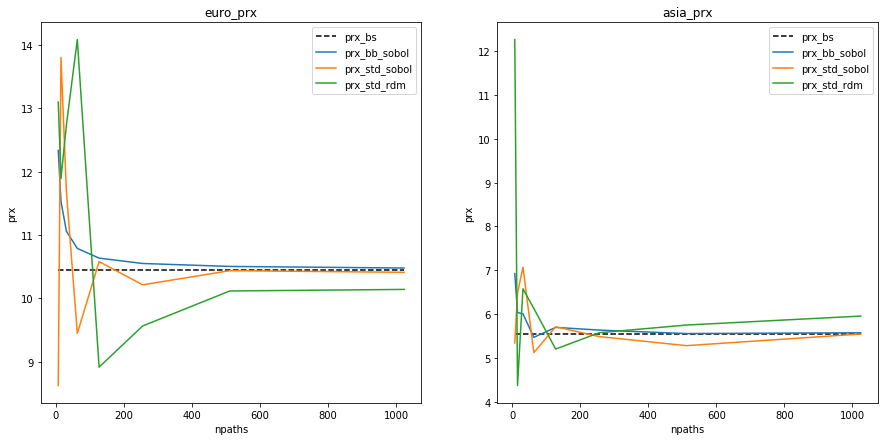

In [19]:
prxerrplot[r;`prx]

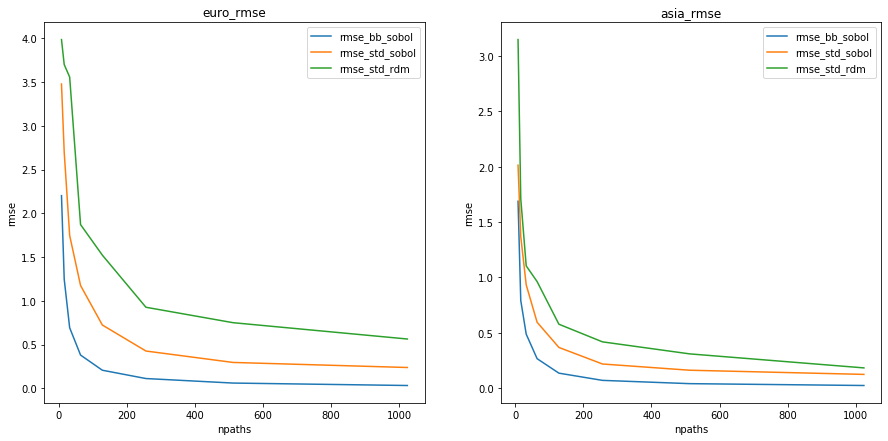

In [20]:
prxerrplot[r;`rmse]

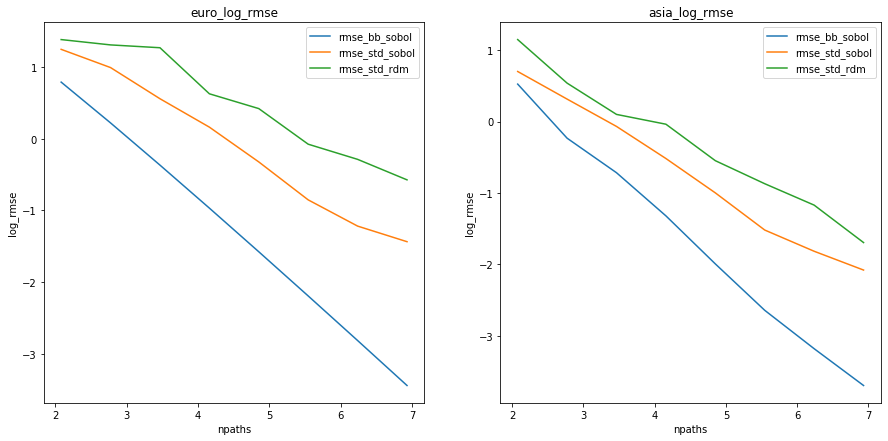

In [21]:
prxerrplot[r;`log]

---

## Conclusion

We have shown that it is possible to calculate option prices using both Black-Scholes and Monte Carlo/Quasi-Monte Carlo methods. The Monte Carlo/Quasi-Monte Carlo methods deploy different implementations of Wiener path approximation and random number generation.

Looking at the results above, it is clear that both the option price produced compared to the Black-Scholes equivalent, and thus the resulting RMSE/log RMSE, converges fastest using the Quasi-Monte Carlo approach with Sobol sequence number generation, paired with Brownian bridge construction.

By plotting the above graphs, it is clear that the q implementation has been able to produce the results obtained in the original paper S. Kucherenko et. al 2007.

---